## NS shop+ 홈쇼핑 매출 EDA
- 2019.01.01~2019.12.31 데이터
- 2020.06월 방송일시별 상품 매출 예측

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 한글 폰트 오류 해결
from matplotlib import font_manager, rc 
font_path = "C:\\Users\\이혜림\\Desktop\\Bita5/malgun.ttf" #폰트 파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)

In [180]:
# 제공 데이터
data = pd.read_csv("./실적데이터.csv") # 내부데이터 (19.01.01~19.12.31) 판매실적 데이터
"""
판매군 -> 무형인 것은 취급액 0 -> 제외 필요
"""
tv = pd.read_csv("./시청률데이터.csv") # 외부데이터(19.01.01~19.12.31) 시청률 데이터
all_app = pd.read_csv("./ns홈쇼핑_app.csv") # 외부데이터(19.01.01~20.05) 어플 사용 데이터

# 평가데이터
submission = pd.read_csv("./평가데이터.csv") # 평가데이터 (2020.06) 판매실적 예측

In [181]:
# ~별 ~칼럼 확인
def calcul(df, by, on): 
    return df.groupby([by])[on].sum()/df.groupby([by])[on].count()

# str 형식 float 형식으로 변환
def to_float(df, column, f, t):
    df[column]=df[column].str.replace(f,t)
    df[column]=df[column].astype(float)

In [182]:
# 방송일시 datatime 형식으로 변환
data["방송일시"]=pd.to_datetime(data["방송일시"])

# 시간 및 요일 feature 추가
data["날짜"]=data["방송일시"].dt.date # 날짜
data["시간"]=data["방송일시"].dt.time # 시,분,초
data["요일"]=data["방송일시"].dt.dayofweek # 요일
data["시"]=data["방송일시"].dt.hour # 시
weekday = {"월":0,"화":1,"수":2,"목":3,"금":4,"토":5,"일":6} # 요일 칼럼 metadata

# 취급액 칼럼의 공백 제거
data.rename({" 취급액 ":"취급액"}, inplace=True, axis=1)

# 취급액, 판매단가 칼럼 int 형식으로 변환
data["취급액"]=data["취급액"].str.replace(",","")
data["판매단가"]=data["판매단가"].str.replace(",","")
data["판매단가"]=data["판매단가"].str.replace(" - ","0")
data["판매단가"]=data["판매단가"].astype(int)
data["취급액"].fillna(0, inplace=True) # NaN 값 0으로 대체
data["취급액"]=data["취급액"].astype(int)

# 주문량 칼럼 추가
data["주문량"]=data["취급액"]/data["판매단가"]

In [203]:
# 어플 사용 데이터
all_app.rename({"End +L10:AA21Date":"Date"}, inplace=True, axis=1) # 칼럼 이름 변화
all_app["Date"]=pd.to_datetime(all_app["Date"]) # datetime 형식으로 변환
all_app["Month"]=all_app["Date"].dt.month

# 년도별로 데이터 나눔
app_2019=all_app[838:1204] # 2019년
app_2020=all_app[1203:]

## 날짜별 어플 데이터와 주문량 데이터의 관계 확인
- 어플 데이터 : active users(0.21), open rate(0.16) 관계성
- 시청률 데이터 : 0.24의 상관계수로 높은 관계성

#### 어플 데이터, 주문량 데이터 관계성

In [204]:
# 날짜별 데이터들의 관계성 확인
day_count = pd.DataFrame(data.groupby("날짜")["주문량"].sum()/data.groupby("날짜")["주문량"].count())
day_count["app_active_users"]=app_2019.groupby(["Date"])["Active Users"].sum()/app_2019.groupby(["Date"])["Active Users"].count()
day_count["app_total_time"]=app_2019.groupby(["Date"])["Total Time"].sum()/app_2019.groupby(["Date"])["Total Time"].count()
to_float(app_2019,"Open Rate","%","")
day_count["app_open_rate"]=calcul(app_2019,"Date","Open Rate")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### 시청률데이터, 주문량 데이터 관계성

In [244]:
day_tv = tv.iloc[1440,1:-1] # 2019 일별 시청률 평균
day_tv.index = day_count.index
day_count["tv"]=day_tv
day_count["tv"]=day_count["tv"].astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [245]:
day_count

,주문량,app_active_users,app_total_time,app_open_rate,tv
날짜,,,,,
2019-01-01,626.326773,135518.0,518301.0,6.47,0.004
2019-01-02,269.711369,142786.0,495837.0,6.81,0.006
2019-01-03,286.823179,137586.0,480828.0,6.57,0.002
2019-01-04,368.702703,125404.0,443206.0,5.98,0.003
2019-01-05,332.687885,126465.0,471235.0,6.04,0.002
...,...,...,...,...,...
2019-12-27,487.310478,141959.0,554642.0,6.76,0.004
2019-12-28,460.032811,140493.0,533299.0,6.69,0.006
2019-12-29,521.240387,136069.0,557799.0,6.50,0.004


,주문량,app_active_users,app_total_time,app_open_rate,tv
주문량,1.000000,0.212340,0.043185,0.156664,0.236652
app_active_users,0.212340,1.000000,0.335674,0.983640,0.310922
app_total_time,0.043185,0.335674,1.000000,0.354593,0.106641
app_open_rate,0.156664,0.983640,0.354593,1.000000,0.280226
tv,0.236652,0.310922,0.106641,0.280226,1.000000


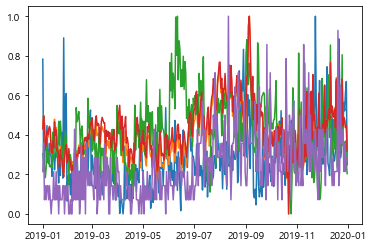

In [246]:
# MinMaxScaler를 통해 그래프에 plot,상관계수 계산 -> 관계성 확인
from sklearn.preprocessing import MinMaxScaler
day_count_scale = pd.DataFrame(MinMaxScaler().fit(day_count).transform(day_count), columns = day_count.columns, index=day_count.index)

plt.plot(day_count_scale)
day_count.corr()

### 날짜, 시간별 취급액

In [66]:
# 방송일시 datatime 형식으로 변환
data["방송일시"]=pd.to_datetime(data["방송일시"])

# 시간 및 요일 feature 추가
data["날짜"]=data["방송일시"].dt.
data["시간"]=data["방송일시"].dt.time # 시,분,초
data["요일"]=data["방송일시"].dt.dayofweek # 요일
data["시"]=data["방송일시"].dt.hour # 시
weekday = {"월":0,"화":1,"수":2,"목":3,"금":4,"토":5,"일":6} # 요일 칼럼 metadata

# 취급액 칼럼의 공백 제거
data.columns = ['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액', '시간', '요일','시']

# 취급액 칼럼 int 형식으로 변환
data["취급액"]=data["취급액"].str.replace(",","")
data["취급액"].fillna(0, inplace=True) # NaN 값 0으로 대체
data["취급액"]=data["취급액"].astype(int)


Text(0.5, 0, "['월', '화', '수', '목', '금', '토', '일']")

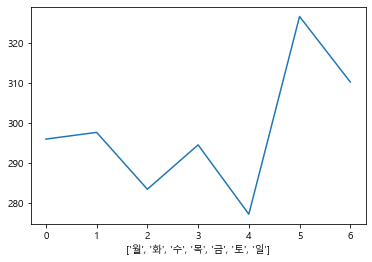

In [120]:
# 요일별 취급액 합계 시각화
plt.plot(data.groupby("요일")["주문량"].sum()/data.groupby("요일")["주문량"].count())
plt.xlabel(list(weekday.keys()))

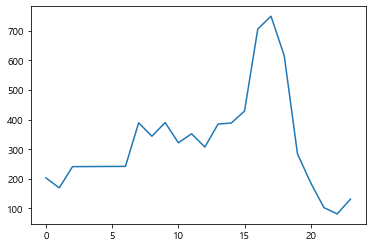

In [121]:
# 시간별 취급액 합계 시각화
plt.plot(data.groupby("시")["주문량"].sum()/data.groupby("시")["주문량"].count())